In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class Agent():
    def __init__(self):
        self.sum = 0
        self.num_of_ace = 0
        self.full_sum = 0
        self.dealer_show = 0
        self.usable_ace = False
        self.game_way = []
        self.Q = {'player_sum':[],'dealer_show':[], 'usable_ace':[], 'action':[], 'G':[], 'value':[], 'num_of_visit':[]}
        for player_sum in range(4, 22):
            for dealer_show in range(2, 12):
                for usable_ace in [True, False]:
                    for action in [0, 1]:
                        self.Q['player_sum'].append(player_sum)
                        self.Q['dealer_show'].append(dealer_show)
                        self.Q['usable_ace'].append(usable_ace)
                        self.Q['action'].append(action)
                        self.Q['G'].append(0)
                        self.Q['value'].append(0)
                        self.Q['num_of_visit'].append(0)
        self.Q = pd.DataFrame(self.Q).set_index(['player_sum', 'dealer_show', 'usable_ace', 'action'])
        self.not_visit_Q = (pd.DataFrame.copy(self.Q).rename(columns={'value':'not usable'})+1).astype(bool)[['not usable']]
    def start_init(self, dealer_show):
        self.sum = 0
        self.num_of_ace = 0
        self.full_sum = 0
        self.usable_ace = False
        self.game_way = []
        self.dealer_show = dealer_show
    def get_action(self):
        state = self.not_visit_Q.loc[self.full_sum, self.dealer_show, self.usable_ace]['not usable']
        if state.sum()==0:
            action = np.random.randint(2)
        else:
            action = state.values.argmax()
        self.not_visit_Q.loc[self.full_sum, self.dealer_show, self.usable_ace, action] = False
        self.Q.loc[(self.full_sum, self.dealer_show, self.usable_ace, action), 'num_of_visit'] += 1
        self.game_way.append((self.full_sum, self.dealer_show, self.usable_ace, action))
        return action
    def update(self, card):
        if card == 't':
            self.num_of_ace += 1
        else:
            self.sum += card
        self.full_sum = self.sum + self.num_of_ace * 11
        if self.full_sum > 21 and self.num_of_ace != 0:
            self.full_sum = self.sum + self.num_of_ace * 1
        if self.num_of_ace == 1:
            self.usable_ace = True
        else:
            self.usable_ace = False
    def get_reward(self, r):
        if r != 0:
            for action in self.game_way:
                self.Q.loc[action,'G'] += r
                self.Q.loc[action,'value'] = self.Q.loc[action,'G']/self.Q.loc[action,'num_of_visit']

class Dealer():
    def __init__(self):
        self.sum = 0
        self.num_of_ace = 0
        self.full_sum = 0
    def update(self, card):
        if card == 't':
            self.num_of_ace += 1
        else:
            self.sum += card
        self.full_sum = self.sum + self.num_of_ace * 11
        if self.full_sum > 21 and self.num_of_ace != 0:
            self.full_sum = self.sum + self.num_of_ace * 1

def geniration_card():
    card = np.random.randint(2, 14, 1)[0]
    if (card >10) and (card<14):
        return 10
    elif card == 14:
        return 't'
    else:
        return card

def game(agent):
    #раздаем диллеру
    dealer = Dealer()
    dealer_open_card = geniration_card()
    dealer.update(dealer_open_card)
    dealer.update(geniration_card())
    #показываем одну карту игроку
    if dealer_open_card == 't':
        agent.start_init(11)
    else:
        agent.start_init(dealer_open_card)
    #раздаем игрока
    agent.update(geniration_card())
    agent.update(geniration_card())
    #Не имеет смысла т.к. не использует стратегии
    if agent.full_sum == 21 or dealer.full_sum == 21:
        return 0
    #Игрок набирает
    while True:
        action = agent.get_action()
        if action == 0:
            break
        else:
            agent.update(geniration_card())
        if agent.full_sum > 21:
            return -1
    #Дилер набирает
    while dealer.full_sum < 17:
        dealer.update(dealer_open_card)
    #Сравниваем
    if agent.full_sum == 21 or agent.full_sum > dealer.full_sum:
        return 1
    elif agent.full_sum == dealer.full_sum:
        return 0
    else:
        return -1
def fit(agent, num_of_epoch, game_for_epoch):
    for epoch in tqdm(range(1, num_of_epoch + 1)):
        for _ in range(game_for_epoch):
            result = game(agent)
            agent.get_reward(result)

In [3]:
agent = Agent()

In [4]:
fit(agent, 20000, 100)

100%|██████████████████████████████████| 20000/20000 [4:09:01<00:00,  1.68it/s]


In [5]:
agent.Q.loc[(14, 9, False, 0),'G']

-9073.0

In [6]:
import seaborn as sns

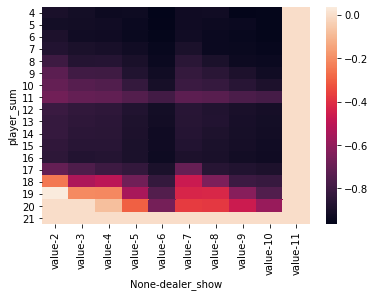

In [7]:
sns.heatmap(agent.Q.loc[np.arange(4,22),:,False].groupby(['player_sum','dealer_show']).mean()[['value']].unstack(level=1))

Вместо трехмерного графика изображен heatmap. Видно, что ценность интересующих нас состояний увеличивается при приближении к "выигрышу", но для более точно картины нужно больше итераций